# 12 Analysis Pipeline 
* KI excluding suspicious slides: **`N07_C1, N06_D2`**
* using new AB index

**Objectives:**
* don't use test data for feature selection step
* perhaps more narrow hyperparameter distributions

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import pickle
import itertools

from numpy import ma  # masked array
from pandas.plotting import parallel_coordinates, andrews_curves, radviz

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.stats.distributions import uniform as sp_uni, randint as sp_int

import seaborn as sns

from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, ShuffleSplit
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

from umap import UMAP

import lime 
from lime.lime_tabular import LimeTabularExplainer

import sklearn.datasets
from lime.lime_tabular import LimeTabularExplainer

sns.set(style="whitegrid")

In [2]:
class EarlyStopMonitor:

    def __init__(self, window_length=25):
        self.window_length = window_length

    def window_boundaries(self, current_round):        
        lo = max(0, current_round - self.window_length + 1)
        hi = current_round + 1

        return lo, hi

    def __call__(self, current_round, regressor, _):        
        if current_round >= self.window_length - 1:
            lo, hi = self.window_boundaries(current_round)
            
            do_stop = np.mean(regressor.oob_improvement_[lo: hi]) < 0
            
            if do_stop:
                print('stopped after rounds: {}'.format(current_round))
            
            return do_stop
        else:
            return False

---

# Load the data

In [3]:
results_wd = '12_results/'

In [4]:
wd = '/media/tmo/data/work/datasets/02_ST'

logcpm_path = wd + '/ashley_21.03.2018/logcpm_merge_20180212.pickle'
meta_path = wd + '/meta/meta.parquet'

In [5]:
%%time
meta_df = pd.read_parquet(meta_path)

CPU times: user 185 ms, sys: 98.1 ms, total: 283 ms
Wall time: 205 ms


In [6]:
%%time
logcpm_df = pickle.load(open(logcpm_path, "rb"))

logcpm_df.index.name = 'spot_UID'
logcpm_df.reset_index(inplace=True)
logcpm_df.rename(columns={'sampleID': 'slide_ID'}, inplace=True)

CPU times: user 15.8 s, sys: 6.51 s, total: 22.4 s
Wall time: 22.3 s


In [7]:
st_df = logcpm_df.merge(meta_df, how='inner', on=['spot_UID', 'slide_ID'])

In [8]:
st_df['slide_ID'] = st_df['slide_ID'].astype('category', copy=False)
st_df['GT']       = st_df['GT'].astype('category', copy=False)
st_df['age']      = st_df['age'].astype('category', copy=False)
st_df['age_GT']   = st_df['age_GT'].astype('category', copy=False)

In [9]:
n_genes = 46454
gene_columns = st_df.columns[1:n_genes+1]

* merge with satellite tables

In [10]:
region_levels_df = pd.read_csv('region_levels.csv', sep=',', keep_default_na=False)

In [11]:
meta_data_path = 'final_metadata_scores_27_04_2018.tsv'

In [12]:
final_meta_df = pd.read_csv(meta_data_path, sep='\t', index_col=0)
final_meta_df.index.name = 'spot_UID'
final_meta_df.reset_index(inplace=True)
final_meta_df = final_meta_df[final_meta_df['AB'].notna()][['spot_UID', 'AB']]

### Log transform AB index
* the AB index is very skewed, this is not ideal for ML algorithm to regress upon
* use a masked array to compute natural log of AB index

cfr. **Jaak Simm**:
> if it is not transformed, the skewness will result in the fact that larger (absolute) deviations will be focused by the model
so lot of focus will be put into these high end values

In [13]:
final_meta_df['log_AB'] = ma.log(final_meta_df['AB'].as_matrix())

* let's check the distributions after log transform
* much nicer (Gaussian-like)
* there is some bimodality going on (could be batch effect, to investigate)

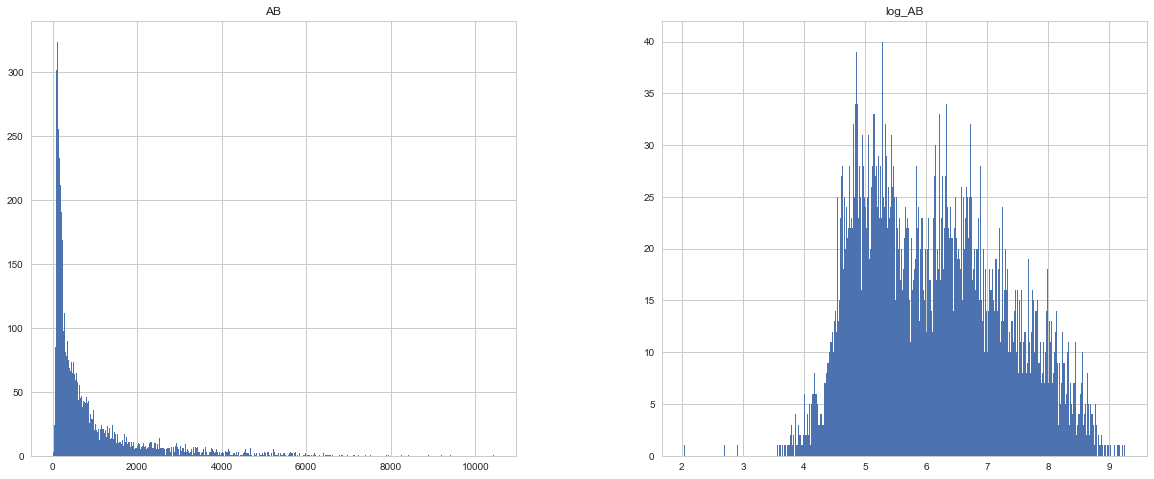

In [14]:
final_meta_df[final_meta_df['log_AB'] > 0][['AB', 'log_AB']].hist(bins=500, figsize=(20, 8))
plt.show()

In [15]:
full_df = st_df \
    .merge(region_levels_df, on='Region_predict') \
    .merge(final_meta_df, on='spot_UID')

In [16]:
log_AB_df = full_df[['log_AB']]

In [48]:
DAM_genes = pd.read_csv('DAM_genes_Keren-Shaul_microglia_cluster3_up.txt', header=None).sort_values(by=0)[0].values

---

# Prepare data 
* exclude suspicious slides: **`N07_C1, N06_D2`**

In [293]:
full_df[['age_days', 'slide_ID', 'spot_UID', 'GT']].groupby(['GT', 'age_days', 'slide_ID']).nunique()

age_days  slide_ID  spot_UID  GT
GT age_days slide_ID                                  
KI 107      N02_C1           1         1       511   1
            N02_D1           1         1       488   1
            N03_C2           1         1       456   1
            N03_D2           1         1       532   1
   186      N07_C1           1         1       478   1
   363      N06_D2           1         1       488   1
   558      N05_C2           1         1       523   1
            N05_D2           1         1       555   1
   559      N04_D1           1         1       460   1
            N04_E1           1         1       490   1
WT 107      B02_D1           1         1       582   1
            B02_E1           1         1       582   1
            B03_C2           1         1       554   1
            B03_D2           1         1       559   1
   183      B07_C2           1         1       537   1
   373      B06_E1           1         1       447   1
   546      B04_D1           1         1       485   1
            B04_E1           1         1       531   1
            B05_D2           1         1       530   1
            B05_E2           1         1       511   1

In [299]:
SUSPICIOUS_SLIDES = ['N07_C1', 'N06_D2']

In [300]:
N07_C1_index = full_df['slide_ID'].isin(SUSPICIOUS_SLIDES)

In [301]:
full_df_clean = full_df.loc[~N07_C1_index]
log_AB_df_clean = log_AB_df.loc[~N07_C1_index]

In [302]:
(full_df_clean.shape, log_AB_df_clean.shape)

((9333, 46766), (9333, 1))

---

# Pipeline implementation

* make an composition of steps that should be cross-validated together
* do feature selection also on training data, never touch test

In [21]:
from tempfile import mkdtemp

def fit_pipeline(X_train, y_train,
                 seed=666,
                 cache_dir='11_cache'):
    
    boruta_estimator = RandomForestRegressor(n_jobs=-1, 
                                             n_estimators=1000, 
                                             max_features='sqrt', 
                                             random_state=seed)
    
    boruta_selector = BorutaPy(estimator=boruta_estimator,
                               max_iter=100,                               
                               verbose=0,
                               random_state=seed)
    
    deep_gbm = GradientBoostingRegressor(learning_rate=0.01,
                                         n_estimators=10000,
                                         subsample=0.9,
                                         max_depth=12,
                                         max_features=0.2,
                                         random_state=seed)
    
    pipeline = Pipeline(memory=cache_dir,
                        steps=[('boruta', boruta_selector),
                               ('deep_gbm', deep_gbm)])
        
    pipeline.fit(X_train, y_train, **{'deep_gbm__monitor': EarlyStopMonitor()})
    
    return pipeline

In [22]:
level_01_regions = region_levels_df.Level_01.unique()

def filter_spots(df,
                 level_01_region=None,
                 genotype=None):
    
    result_df = df
    
    if level_01_region:
        assert level_01_region in level_01_regions        
        result_df = result_df[result_df['Level_01'] == level_01_region]
        
    if genotype:
        assert genotype in ['WT', 'KI']
        result_df = result_df[result_df['GT'] == genotype]
        
    return result_df

In [23]:
def split_train_test(df,
                     groups=None,
                     splitter=ShuffleSplit(n_splits=1, test_size=0.15, random_state=42)):
    
    train_idx, test_idx = list(splitter.split(df, groups=groups))[0]
    
    return train_idx, test_idx

In [24]:
def make_datasets(df, level_01_region, genotype, group_col='slide_ID'):
    filtered_df = filter_spots(df, level_01_region, genotype)
    
    train_idx, test_idx = split_train_test(filtered_df, filtered_df[group_col].cat.codes)
    
    X_train = filtered_df.iloc[train_idx]
    y_train = filtered_df['log_AB'].iloc[train_idx]
    
    X_test = filtered_df.iloc[test_idx]
    y_test = filtered_df['log_AB'].iloc[test_idx]
    
    return (X_train, y_train), (X_test, y_test)

In [25]:
def important_genes(pipeline):
    boruta_selector = pipeline.steps[0][1]
    importance_regressor = pipeline.steps[1][1]
    
    boruta_genes = list(gene_columns[boruta_selector.support_])
    
    important_genes_df = pd.DataFrame({'gene': boruta_genes,
                                       'importance': importance_regressor.feature_importances_}).sort_values(by='importance', ascending=False)
    
    return boruta_genes, important_genes_df    

In [149]:
def plot_test_predictions(pipeline, X_test, y_test):
    gbm = pipeline.steps[1][1]
    
    predictions_df = pd.DataFrame({'predict': gbm.predict(X_test.as_matrix()),
                                   'actual': y_test.values.ravel()})
    
    sns.jointplot("actual", "predict", data=predictions_df, kind="reg", color="g", size=7)
    #plt.gca().set_aspect('equal', adjustable='box')
    
    plt.show()

In [27]:
def plot_pdp(pipeline, X_train, top=24):
    top_genes = important_genes(pipeline)[1]['gene'][:top]
    
    boruta_selector = pipeline.steps[0][1]
    importance_regressor = pipeline.steps[1][1]
    
    boruta_genes = list(gene_columns[boruta_selector.support_])
    
    gene_indices = [boruta_genes.index(gene) for gene in top_genes]
    
    plot_partial_dependence(importance_regressor,
                            X=X_train[boruta_genes],
                            features=gene_indices,
                            feature_names=boruta_genes,
                            grid_resolution=100,
                            n_jobs=1, figsize=(12, 32))
    
    plt.show()

In [28]:
def plot_individual_pdp(pipeline, X_train, genes=[]):    
    
    boruta_selector = pipeline.steps[0][1]
    importance_regressor = pipeline.steps[1][1]
    
    boruta_genes = list(gene_columns[boruta_selector.support_])
    
    gene_indices = [boruta_genes.index(gene) for gene in genes]
    
    for idx, gene in enumerate(genes):
        plot_partial_dependence(best_estimator,
                                X=X_train,
                                features=[boruta_genes.index(gene)],
                                feature_names=boruta_genes,                        
                                figsize=(4, 4))
    
        plt.show()        

In [29]:
def valid_for_iCisTarget(gene):
    return not (gene.startswith('Gm') | gene.startswith('mt-')) 

---

# **<< KI ONLY >>**



---

# CX

In [303]:
(CX_KI_X_train, CX_KI_y_train), (CX_KI_X_test, CX_KI_y_test) = make_datasets(full_df_clean, 'CX', 'KI')

In [ ]:
%%time
CX_KI_pipeline = fit_pipeline(CX_KI_X_train[gene_columns].as_matrix(), 
                              CX_KI_y_train.values.ravel())

In [305]:
CX_KI_boruta_genes, CX_KI_important_genes_df = important_genes(CX_KI_pipeline)

In [306]:
CX_KI_important_genes_df.shape

(160, 2)

In [307]:
set.intersection(set(CX_KI_boruta_genes), set(DAM_genes))

{'Apoe',
 'B2m',
 'Ccl6',
 'Cd52',
 'Cd63',
 'Cd68',
 'Cd74',
 'Cd9',
 'Clec7a',
 'Cox4i1',
 'Cst7',
 'Ctsa',
 'Ctsb',
 'Ctsd',
 'Ctsl',
 'Ctss',
 'Ctsz',
 'Fcer1g',
 'Fth1',
 'Gm10073',
 'Gm10269',
 'Gm11410',
 'Gm13340',
 'Gm17511',
 'Gm5244',
 'Gm5963',
 'Gpnmb',
 'Grn',
 'H2-D1',
 'H2-K1',
 'Hexa',
 'Itgax',
 'Lgals3bp',
 'Lyz1',
 'Lyz2',
 'Mpeg1',
 'Npc2',
 'Rnaset2a',
 'Rplp1',
 'Spp1',
 'Tpi1',
 'Trem2',
 'Tyrobp'}

In [308]:
CX_KI_important_genes_df.to_csv(results_wd + 'CX_KI_important_genes.tsv', sep='\t', index=None)

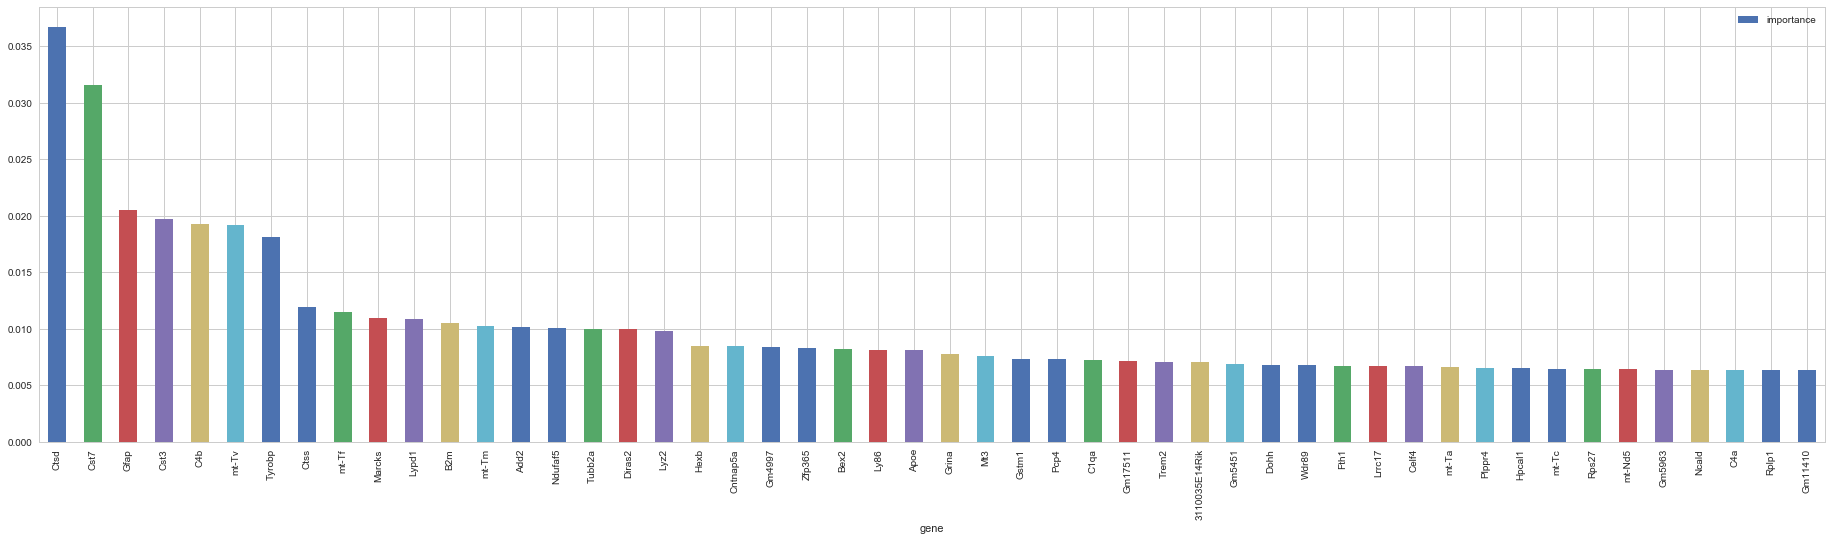

In [309]:
CX_KI_important_genes_df[:50].plot.bar(x='gene', y='importance', figsize=(32, 8))
plt.show()

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


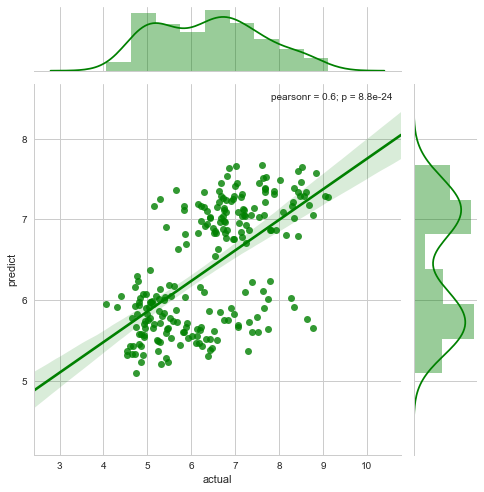

In [310]:
plot_test_predictions(CX_KI_pipeline, CX_KI_X_test[CX_KI_boruta_genes], CX_KI_y_test)

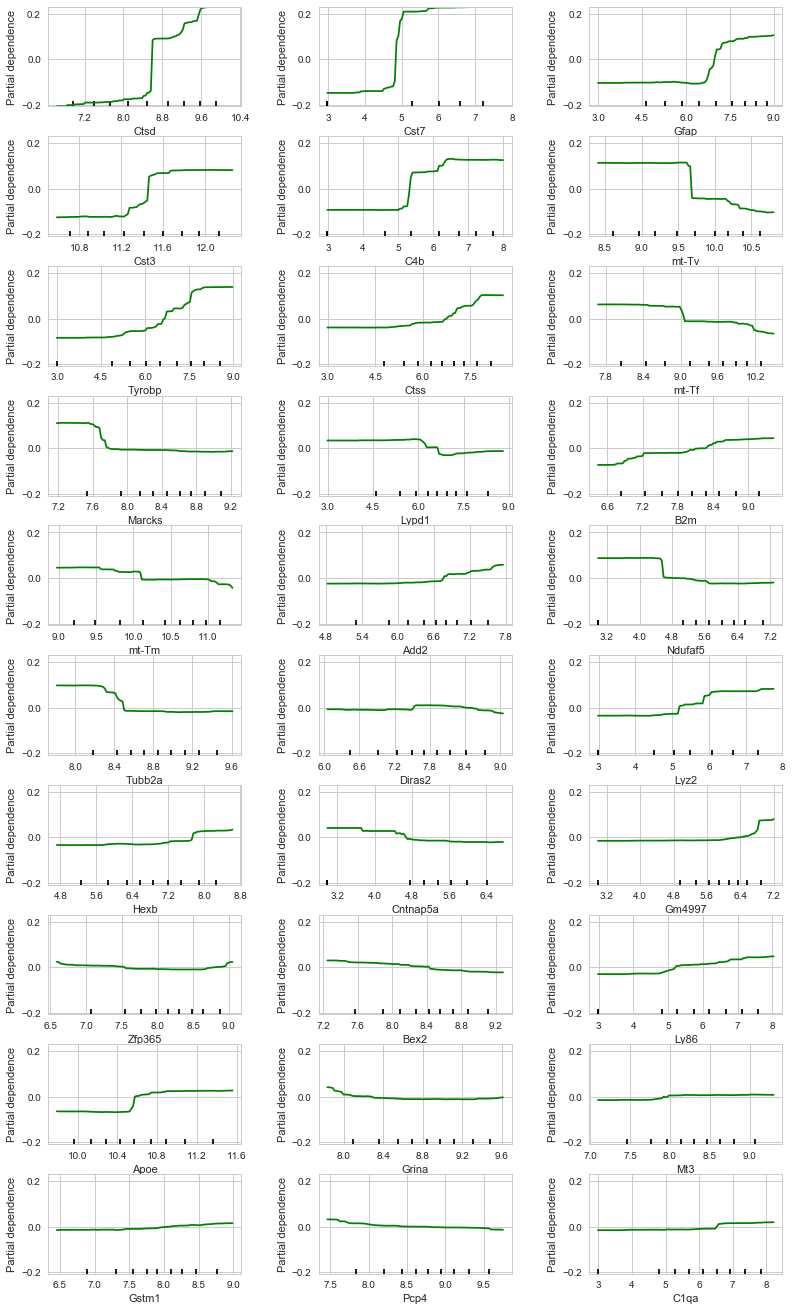

In [311]:
plot_pdp(CX_KI_pipeline, CX_KI_X_train, top=30)

---

# **BS**

In [312]:
(BS_KI_X_train, BS_KI_y_train), (BS_KI_X_test, BS_KI_y_test) = make_datasets(full_df_clean, 'BS', 'KI')

In [ ]:
%%time
BS_KI_pipeline = fit_pipeline(BS_KI_X_train[gene_columns].as_matrix(), 
                              BS_KI_y_train.values.ravel())

In [314]:
BS_KI_boruta_genes, BS_KI_important_genes_df = important_genes(BS_KI_pipeline)

In [315]:
BS_KI_important_genes_df.shape

(149, 2)

In [346]:
np.array(list(set.intersection(set(BS_KI_boruta_genes), set(DAM_genes))))

array(['Fcer1g', 'Apoe', 'Lyz2', 'Spp1', 'Gm13341', 'Cd9', 'Ftl1', 'Ctsd',
       'Ctsa', 'Fth1', 'Fxyd6', 'Mpeg1', 'H2-D1', 'Gm3511', 'Gpnmb',
       'Cd74', 'Itgax', 'Ccl6', 'Cd52', 'Ctsb', 'Gm11410', 'Cd68', 'Ctsz',
       'B2m', 'Cst7', 'Gm10059', 'Ctss', 'Hexa', 'Tyrobp', 'Clec7a',
       'Rpl22l1', 'Cox4i1', 'Trem2', 'Grn'], 
      dtype='<U7')

In [317]:
BS_KI_important_genes_df.to_csv(results_wd + 'BS_KI_important_genes.tsv', sep='\t', index=None)

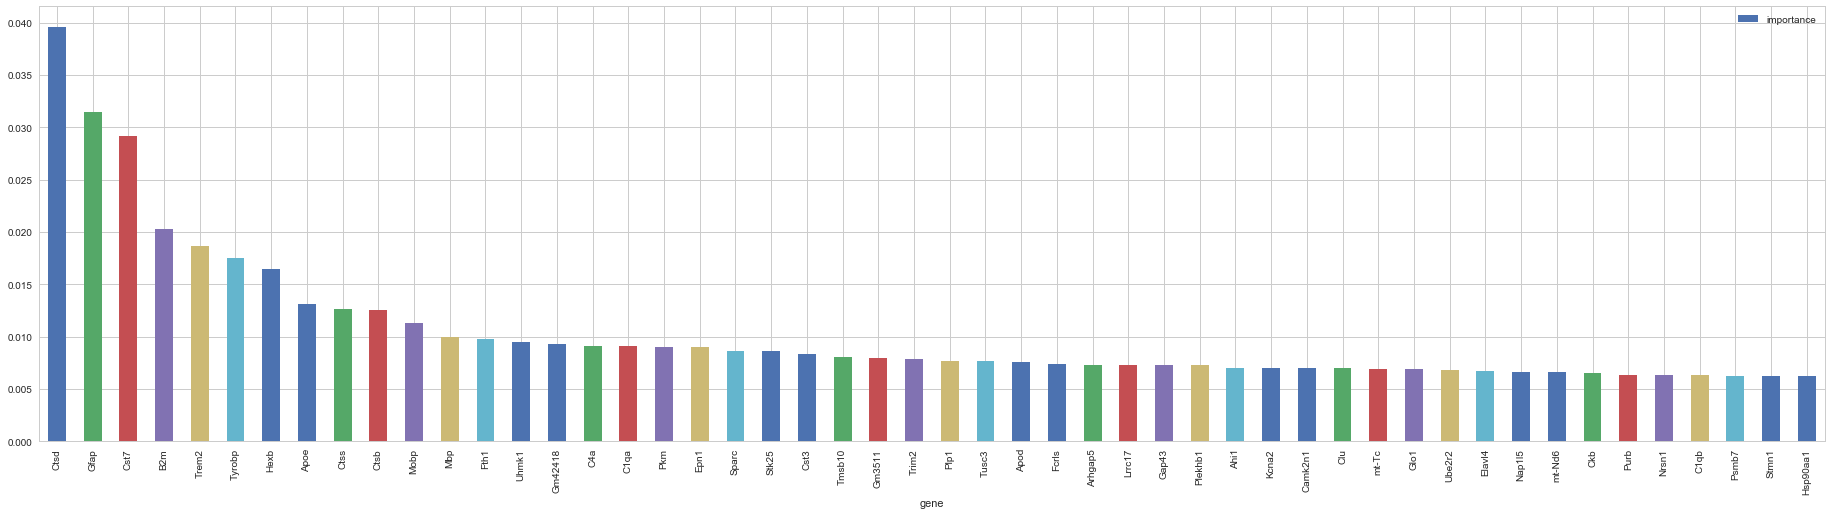

In [318]:
BS_KI_important_genes_df[:50].plot.bar(x='gene', y='importance', figsize=(32, 8))
plt.show()

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


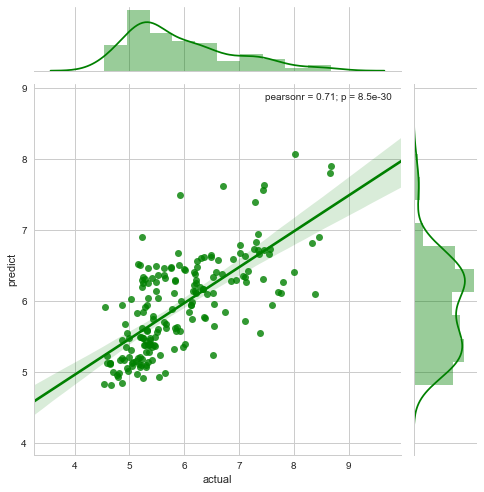

In [319]:
plot_test_predictions(BS_KI_pipeline, BS_KI_X_test[BS_KI_boruta_genes], BS_KI_y_test)

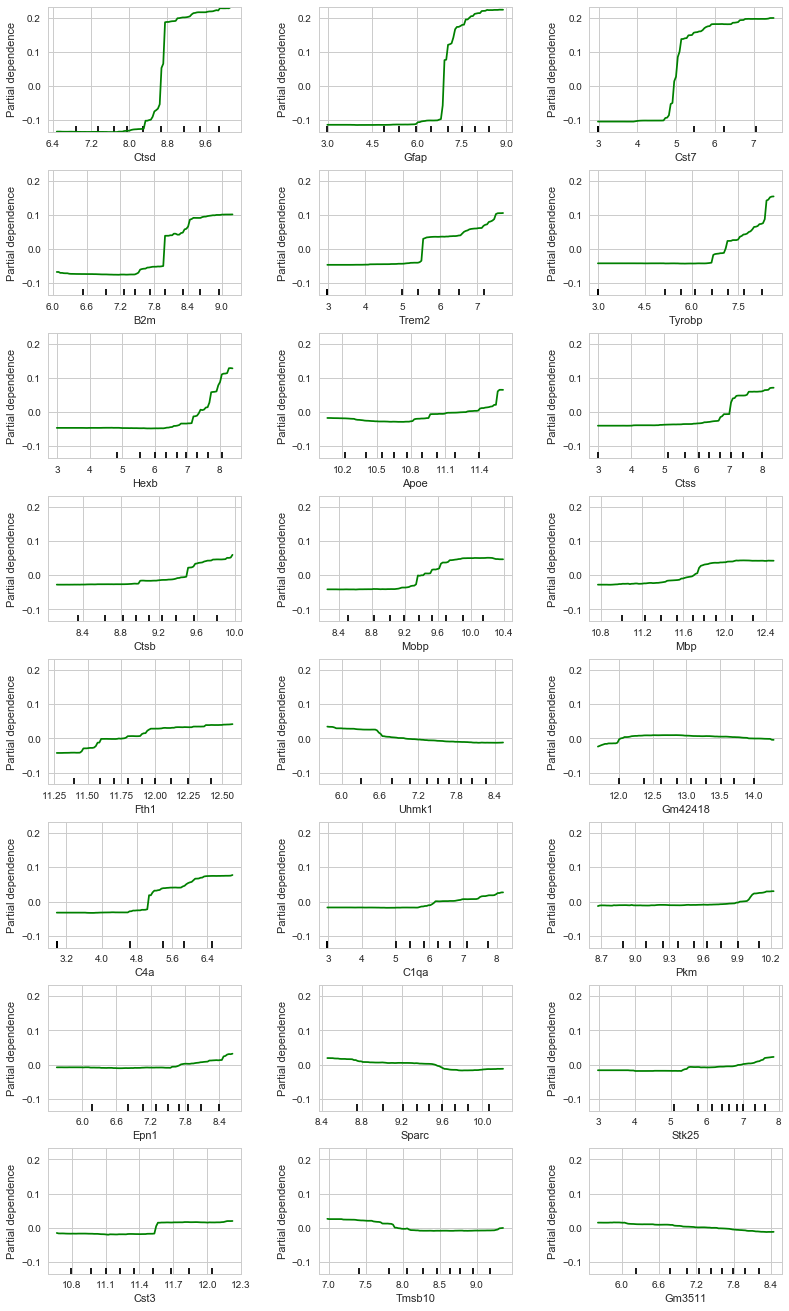

In [320]:
plot_pdp(BS_KI_pipeline, BS_KI_X_train)

---

# **HP**

In [321]:
(HP_KI_X_train, HP_KI_y_train), (HP_KI_X_test, HP_KI_y_test) = make_datasets(full_df_clean, 'HP', 'KI')

In [ ]:
%%time
HP_KI_pipeline = fit_pipeline(HP_KI_X_train[gene_columns].as_matrix(), 
                              HP_KI_y_train.values.ravel())

In [323]:
HP_KI_boruta_genes, HP_KI_important_genes_df = important_genes(HP_KI_pipeline)

In [324]:
HP_KI_important_genes_df.shape

(84, 2)

In [325]:
HP_KI_important_genes_df.to_csv(results_wd + 'HP_KI_important_genes.tsv', sep='\t', index=None)

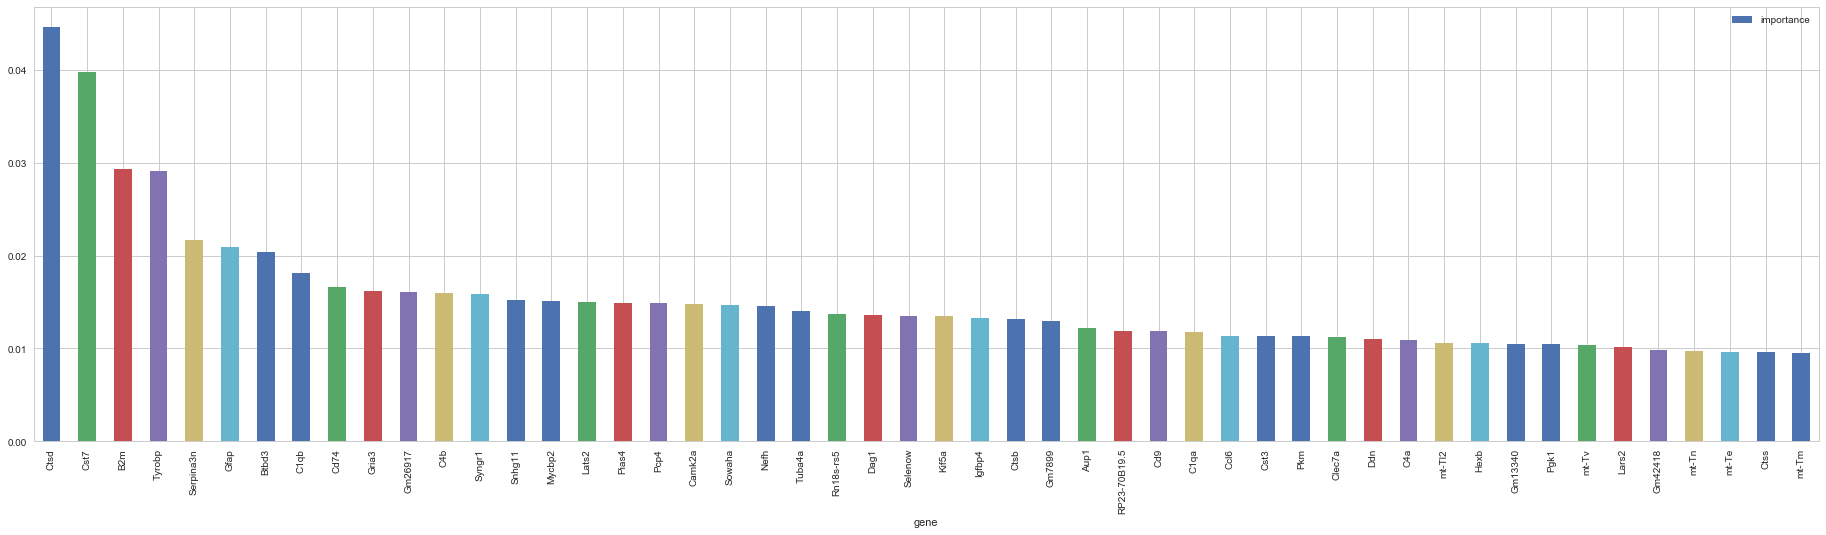

In [326]:
HP_KI_important_genes_df[:50].plot.bar(x='gene', y='importance', figsize=(32, 8))
plt.show()

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


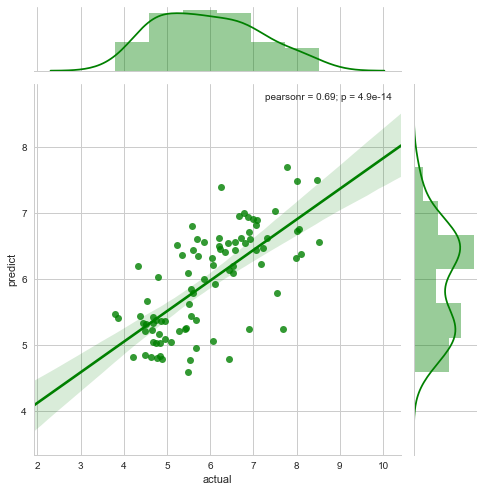

In [327]:
plot_test_predictions(HP_KI_pipeline, HP_KI_X_test[HP_KI_boruta_genes], HP_KI_y_test)

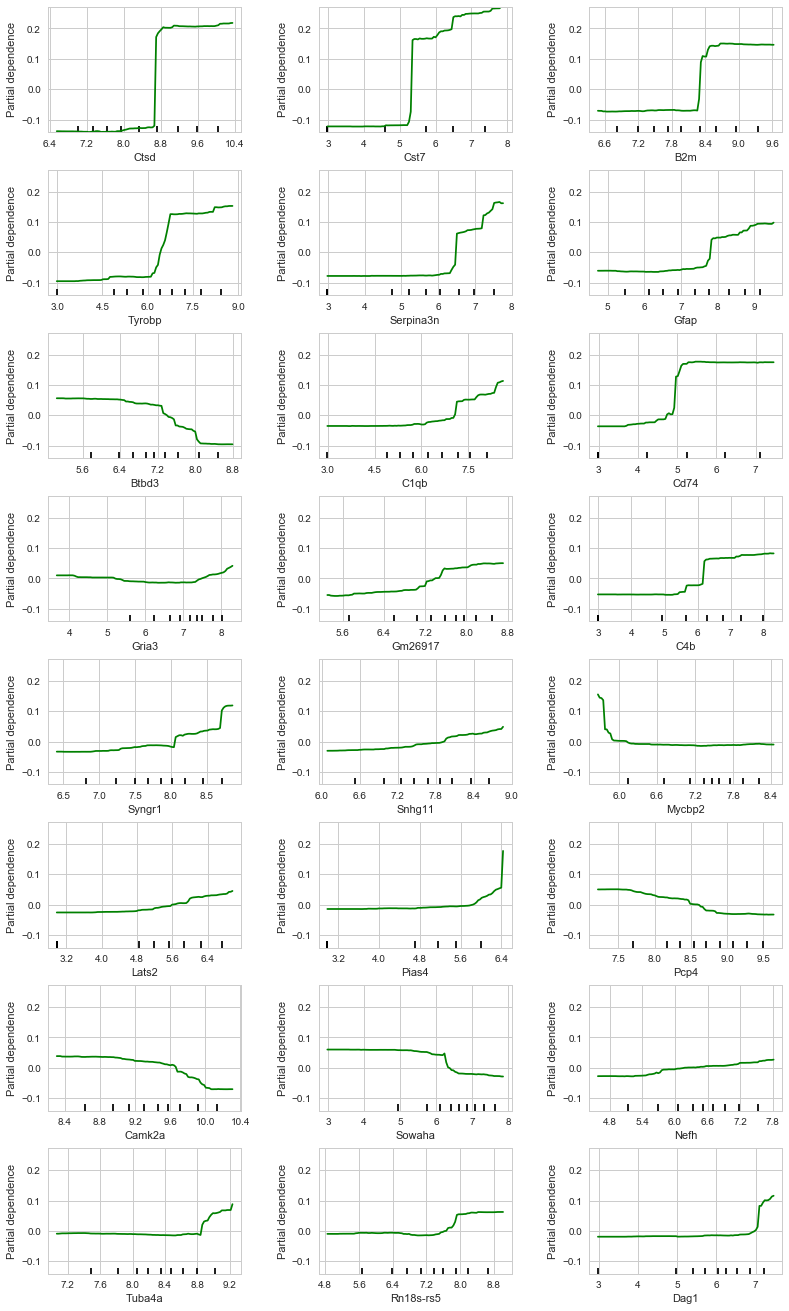

In [328]:
plot_pdp(HP_KI_pipeline, HP_KI_X_train)

---

# ALL level 01 spots

In [329]:
(ALL_KI_X_train, ALL_KI_y_train), (ALL_KI_X_test, ALL_KI_y_test) = make_datasets(full_df_clean, 
                                                                                 level_01_region=None, 
                                                                                 genotype='KI')

In [330]:
%%time
ALL_KI_pipeline = fit_pipeline(ALL_KI_X_train[gene_columns].as_matrix(), 
                               ALL_KI_y_train.values.ravel())

stopped after rounds: 544
CPU times: user 5h 38min 20s, sys: 4min 52s, total: 5h 43min 13s
Wall time: 13min 5s


In [333]:
ALL_KI_boruta_genes, ALL_KI_important_genes_df = important_genes(ALL_KI_pipeline)

In [334]:
pipe_sgbm = ALL_KI_pipeline.steps[1][1]

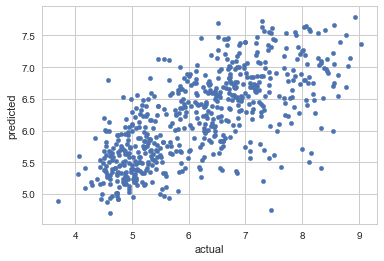

In [335]:
pd.DataFrame({'predicted': pipe_sgbm.predict(ALL_KI_X_test[ALL_KI_boruta_genes]), 'actual': ALL_KI_y_test}).plot.scatter(x='actual', y='predicted')
plt.show()

TODO pickle the models in the pipeline -> load them later

In [336]:
len(ALL_KI_boruta_genes)

231

In [350]:
ALL_KI_DAM_genes = list(set.intersection(set(ALL_KI_boruta_genes), set(DAM_genes)))
ALL_KI_DAM_genes.sort()
ALL_KI_DAM_genes

['Apoe',
 'B2m',
 'Ccl6',
 'Cd52',
 'Cd68',
 'Cd74',
 'Cd9',
 'Clec7a',
 'Cox4i1',
 'Cst7',
 'Ctsa',
 'Ctsb',
 'Ctsd',
 'Ctsl',
 'Ctss',
 'Ctsz',
 'Fcer1g',
 'Fth1',
 'Ftl1',
 'Gm10059',
 'Gm10925',
 'Gm11410',
 'Gm13340',
 'Gm17511',
 'Gpnmb',
 'Grn',
 'H2-D1',
 'Hexa',
 'Itgax',
 'Lgals3bp',
 'Lpl',
 'Lyz1',
 'Lyz2',
 'Mamdc2',
 'Man2b1',
 'Mpeg1',
 'Npc2',
 'Pea15a',
 'Pld3',
 'Rpl22l1',
 'Rpl32',
 'Rplp1',
 'Scd2',
 'Spp1',
 'Syngr1',
 'Timp2',
 'Tpi1',
 'Trem2',
 'Tyrobp',
 'Uqcr11']

In [337]:
ALL_KI_important_genes_df.to_csv(results_wd + 'ALL_KI_important_genes.tsv', sep='\t', index=None)

In [338]:
# ALL_KI_important_genes_df = pd.read_csv(results_wd + 'ALL_KI_important_genes.tsv', sep='\t')

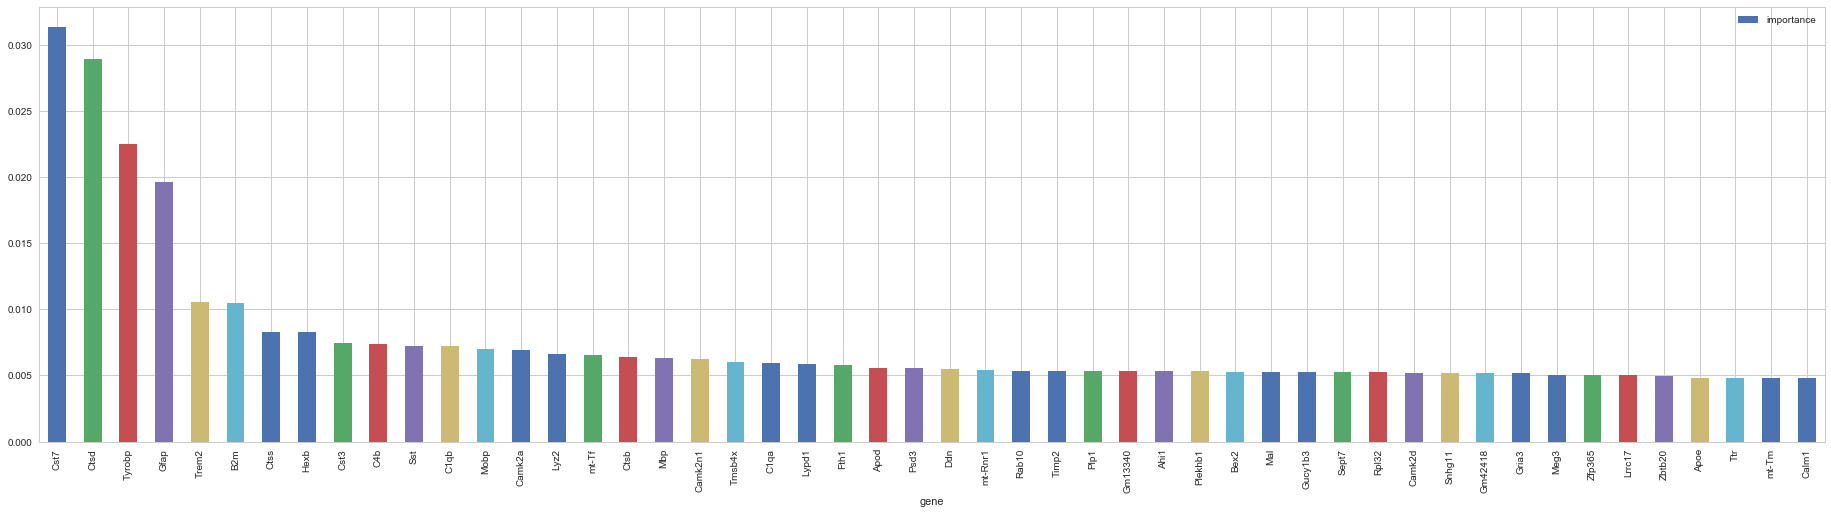

In [339]:
ALL_KI_important_genes_df[:50].plot.bar(x='gene', y='importance', figsize=(32, 8))
plt.show()

In [340]:
ALL_KI_X_test[ALL_KI_boruta_genes].shape

(603, 231)

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


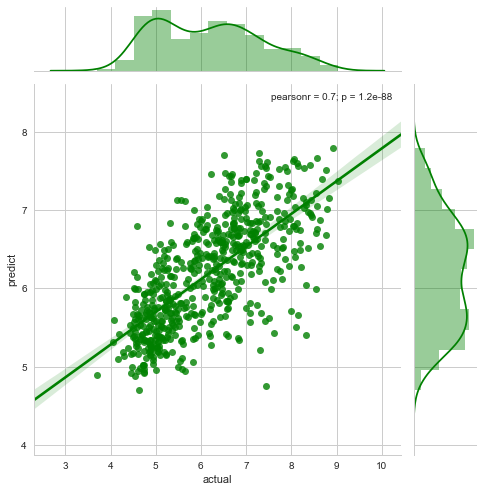

In [341]:
plot_test_predictions(ALL_KI_pipeline, ALL_KI_X_test[ALL_KI_boruta_genes], ALL_KI_y_test)

# TODO put this in a function

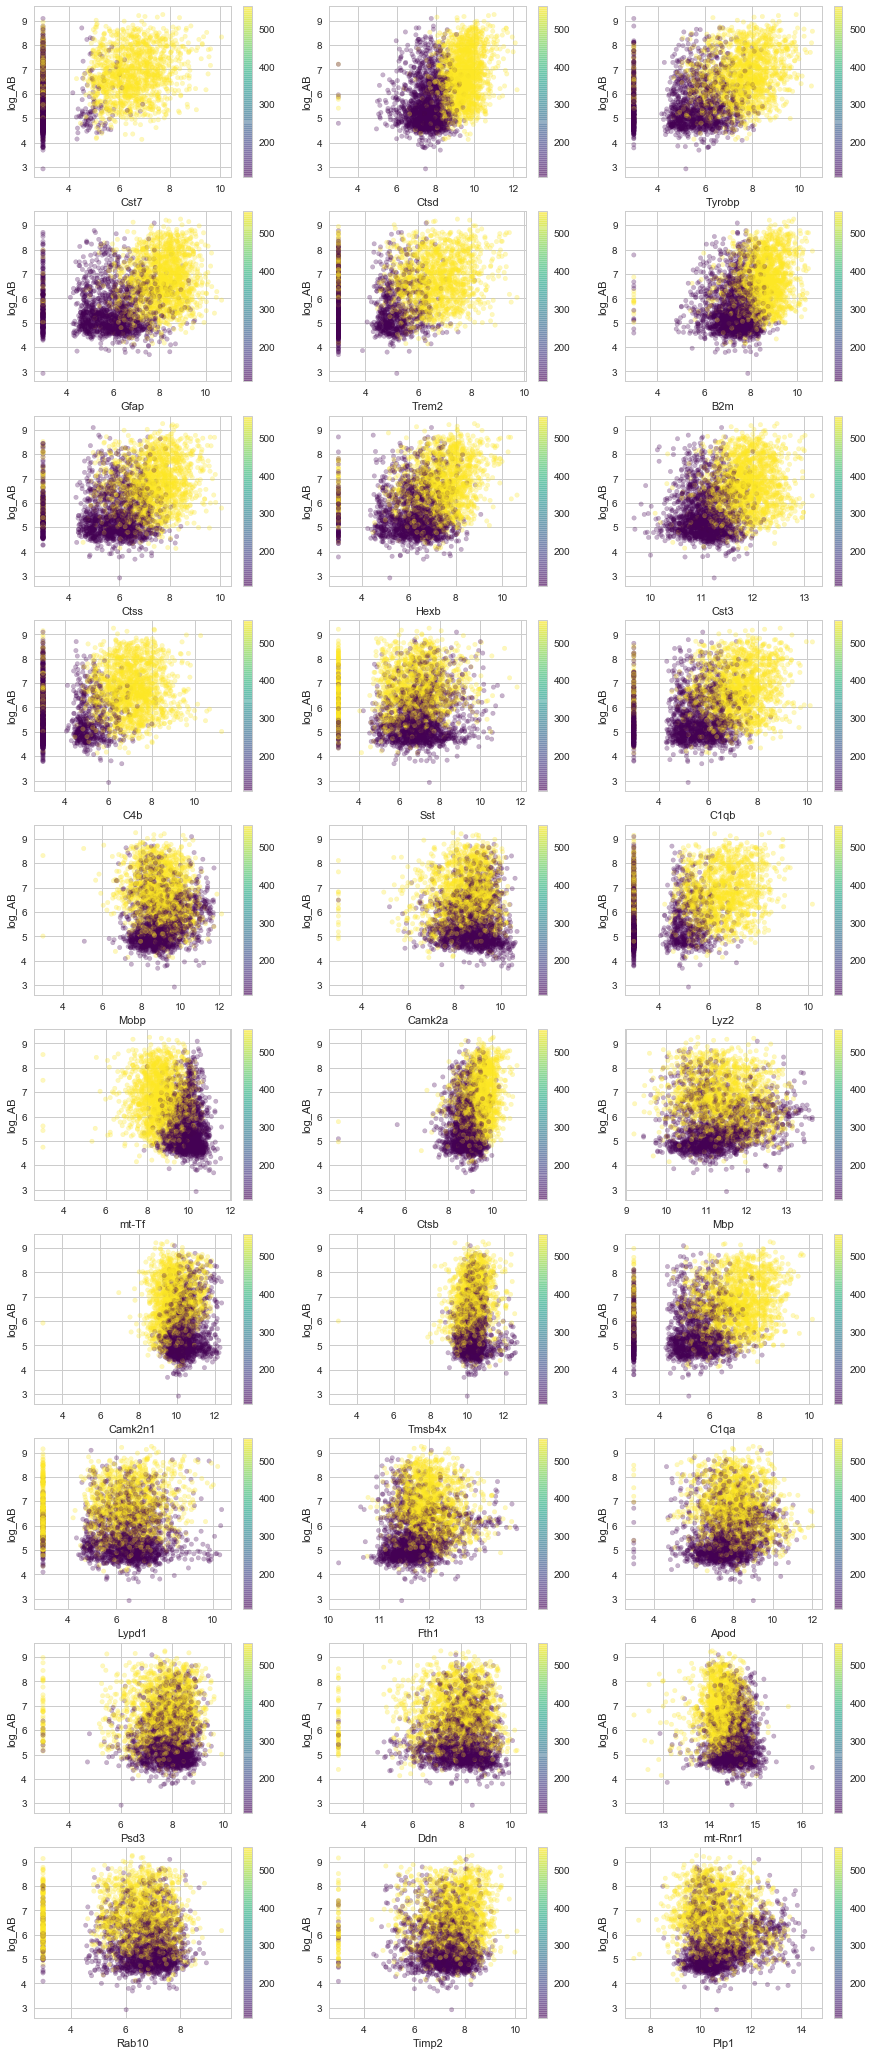

In [355]:
top = 30

fig, axs = plt.subplots(nrows=int(top/3), ncols=3, figsize=(15, int(top * 1.25)))

axes = axs.flatten()

for i, gene in enumerate(ALL_KI_important_genes_df['gene'].values[:top]):    
    f = pd.DataFrame({gene: ALL_KI_X_train[gene], 'log_AB': ALL_KI_y_train}).plot.scatter(x=gene, y='log_AB', alpha=0.3, ax=axes[i], c=ALL_KI_X_train['age_days'], cmap='viridis')
    
plt.show()    

In [343]:
set.intersection(set(ALL_KI_boruta_genes), set(DAM_genes))

{'Apoe',
 'B2m',
 'Ccl6',
 'Cd52',
 'Cd68',
 'Cd74',
 'Cd9',
 'Clec7a',
 'Cox4i1',
 'Cst7',
 'Ctsa',
 'Ctsb',
 'Ctsd',
 'Ctsl',
 'Ctss',
 'Ctsz',
 'Fcer1g',
 'Fth1',
 'Ftl1',
 'Gm10059',
 'Gm10925',
 'Gm11410',
 'Gm13340',
 'Gm17511',
 'Gpnmb',
 'Grn',
 'H2-D1',
 'Hexa',
 'Itgax',
 'Lgals3bp',
 'Lpl',
 'Lyz1',
 'Lyz2',
 'Mamdc2',
 'Man2b1',
 'Mpeg1',
 'Npc2',
 'Pea15a',
 'Pld3',
 'Rpl22l1',
 'Rpl32',
 'Rplp1',
 'Scd2',
 'Spp1',
 'Syngr1',
 'Timp2',
 'Tpi1',
 'Trem2',
 'Tyrobp',
 'Uqcr11'}

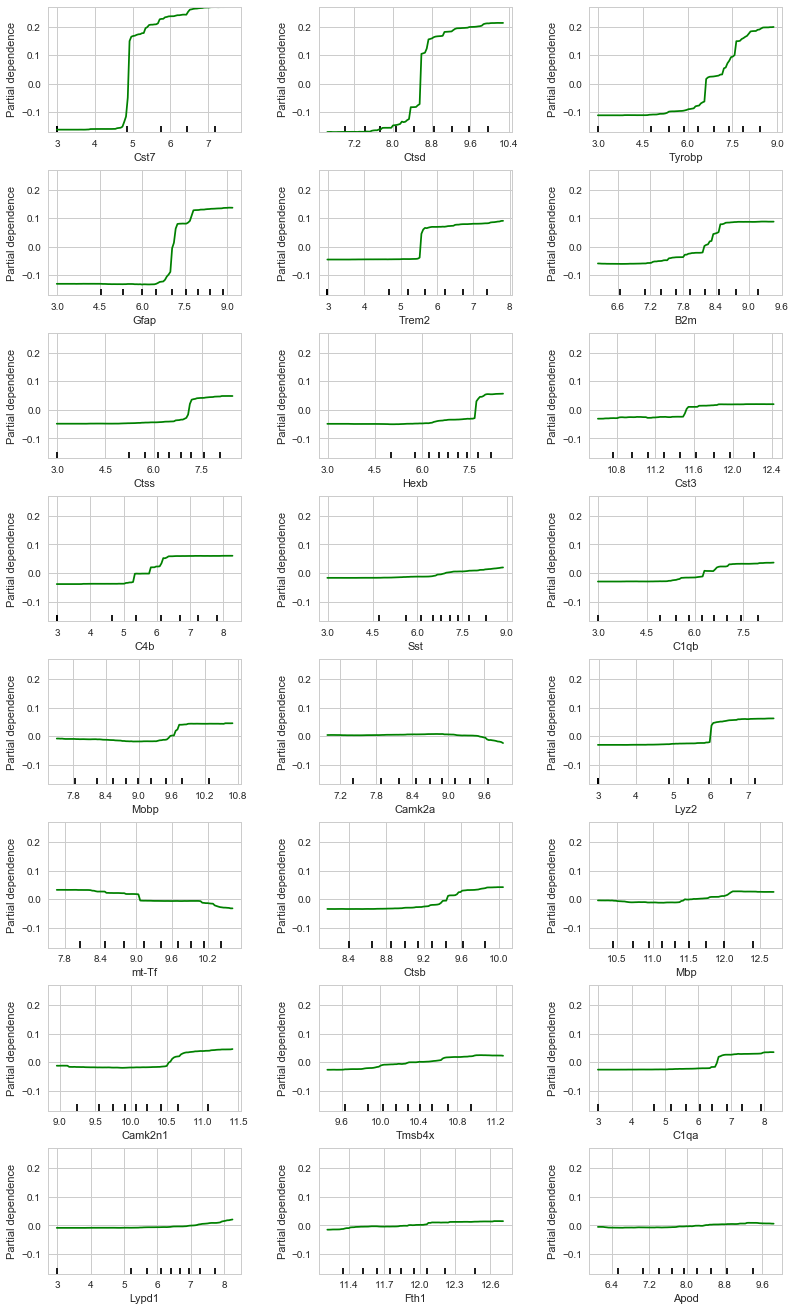

In [356]:
plot_pdp(ALL_KI_pipeline, ALL_KI_X_train)

---

In [164]:
(ALL_WT_X_train, ALL_WT_y_train), (ALL_WT_X_test, ALL_WT_y_test) = make_datasets(full_df, 
                                                                                 level_01_region=None, 
                                                                                 genotype='WT')

In [249]:
def rand_jitter(arr, stdev=1):    
    return arr + np.random.randn(len(arr)) * stdev

In [198]:
def jitter(n):    
    return np.random.randn(n)

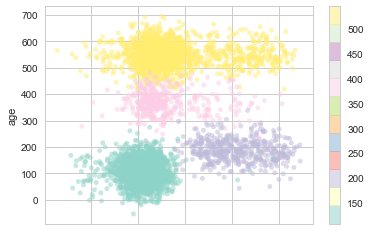

In [244]:
mt_gene = 'mt-Rnr2'

ALL_WT_mt_Tf = pd.DataFrame({mt_gene: ALL_WT_X_train[mt_gene], 'age': rand_jitter(ALL_WT_X_train['age_days'].values, f=0.1)})
ALL_WT_mt_Tf.plot.scatter(x=mt_gene, y='age', c=ALL_WT_X_train['age_days'], cmap='Set3', alpha=0.5)
#ALL_WT_mt_Tf.plot.scatter(x=mt_gene, y='age', alpha=0.1) #, c=ALL_WT_X_train['age_days'], cmap='viridis_r', alpha=0.1)
plt.show()

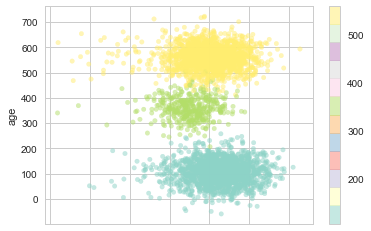

In [230]:
ALL_WT_mt_Tf = pd.DataFrame({mt_gene: ALL_KI_X_train[mt_gene], 'age': rand_jitter(ALL_KI_X_train['age_days'].values)})
ALL_WT_mt_Tf.plot.scatter(x=mt_gene, y='age', alpha=0.5, c=ALL_KI_X_train['age_days'], cmap='Set3')
plt.show()

---

# Keras doodles

## 01 Sequential model: regression to predict log_AB plaque load

In [84]:
ALL_KI_boruta_genes_df = pd.read_csv(results_wd + 'ALL_KI_important_genes.tsv', sep='\t')

In [85]:
ALL_KI_boruta_genes = list(ALL_KI_boruta_genes_df['gene'])

In [86]:
from keras import models
from keras import layers

from keras import regularizers
from keras.datasets import mnist
from keras.utils import to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [87]:
nr_inputs = len(ALL_KI_boruta_genes)
nr_inputs

302

In [88]:
splitter = ShuffleSplit(n_splits=10, test_size=0.15, random_state=42)

In [89]:
train_idx, val_idx = next(splitter.split(ALL_KI_X_train))

In [90]:
ALL_KI_X_train.shape

(3827, 46766)

In [93]:
ALL_KI_X_full_train = ALL_KI_X_train[ALL_KI_boruta_genes].iloc[train_idx].astype('float16')

ALL_KI_X_partial_train = ALL_KI_X_train[ALL_KI_boruta_genes].iloc[train_idx]
ALL_KI_y_partial_train = ALL_KI_y_train.iloc[train_idx]

ALL_KI_X_val = ALL_KI_X_train[ALL_KI_boruta_genes].iloc[val_idx]
ALL_KI_X_full_val = ALL_KI_X_train[ALL_KI_boruta_genes].iloc[val_idx].astype('float16')
ALL_KI_y_val = ALL_KI_y_train.iloc[val_idx]

In [94]:
slide_ID_by_age_df = df.groupby(['slide_ID', 'age_days']).size().reset_index().sort_values(by='age_days')
slide_IDs_by_age = slides_ID_by_age_df['slide_ID']

NameError: name 'df' is not defined

In [ ]:
slide_ID_by_age_df

In [ ]:
gene = 'mt-Rnr1'

df = full_df[full_df['GT'] == 'KI'][[gene, 'log_AB', 'Level_01', 'age_days', 'slide_ID']].copy()
df['Level_01'] = df['Level_01'].astype('category', copy=False)

In [ ]:
f, axes = plt.subplots(nrows=10, ncols=1, figsize=(3, 39))

for idx, slide in enumerate(slide_IDs_by_age):
    df.plot.scatter(x=gene, y='log_AB', c=(df['slide_ID'] == slide).astype(int), alpha=0.2, cmap='viridis_r', ax=axes[idx])
    axes[idx].legend([slide])
    
plt.savefig('{}_to_log_AB_by_slide_ID.png'.format(gene))
plt.show()

In [95]:
class controlled():
    
    def __init__(self, network_factory_fn):
        self.factory = network_factory_fn
    
    def __enter__(self):
        return self.factory()
    
    def __exit__(self, type, network, traceback):
        if network:
            del network
        gc.collect()

In [96]:
def make_network():
    network = models.Sequential()
    network.add(layers.Dense(64, activation='elu', input_shape=(ALL_KI_X_partial_train.shape[1], )))
    network.add(layers.Dense(64, activation='elu'))
    network.add(layers.Dense(64, activation='elu'))
    network.add(layers.Dense(1))

    network.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return network

In [97]:
def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]            
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
            
    return smoothed_points

In [98]:
def make_network_reg_l1():
    network = models.Sequential()
    network.add(layers.Dense(64, activation='elu', input_shape=(ALL_KI_X_partial_train.shape[1], ), kernel_regularizer=regularizers.l1(0.01)))    
    network.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l1(0.01)))
    network.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l1(0.01)))
    network.add(layers.Dense(1))

    network.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return network

In [99]:
def make_network_reg_l2():
    n_units=16
    act_fn='elu'
    drop_frac=0.2
    
    network = models.Sequential()
    network.add(layers.Dense(n_units, activation=act_fn, input_shape=(ALL_KI_X_partial_train.shape[1], ), kernel_regularizer=regularizers.l2(0.1)))
    network.add(layers.Dropout(drop_frac))
    network.add(layers.Dense(n_units, activation=act_fn, kernel_regularizer=regularizers.l2(0.1)))
    network.add(layers.Dropout(drop_frac))
    network.add(layers.Dense(n_units, activation=act_fn, kernel_regularizer=regularizers.l2(0.1)))
    network.add(layers.Dropout(drop_frac))
    network.add(layers.Dense(n_units, activation=act_fn, kernel_regularizer=regularizers.l2(0.1)))
    network.add(layers.Dropout(drop_frac))
    network.add(layers.Dense(1))

    network.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    print(network.summary())
    
    return network

In [100]:
%%time
try:
    del network_01
except:
    pass
    
gc.collect()

network_01 = make_network_reg_l2()

n_epochs = 400

history = network_01.fit(ALL_KI_X_partial_train,
                         ALL_KI_y_partial_train,
                         epochs=n_epochs,
                         batch_size=128,
                         verbose=0,
                         validation_data=(ALL_KI_X_val, ALL_KI_y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                4848      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
__________

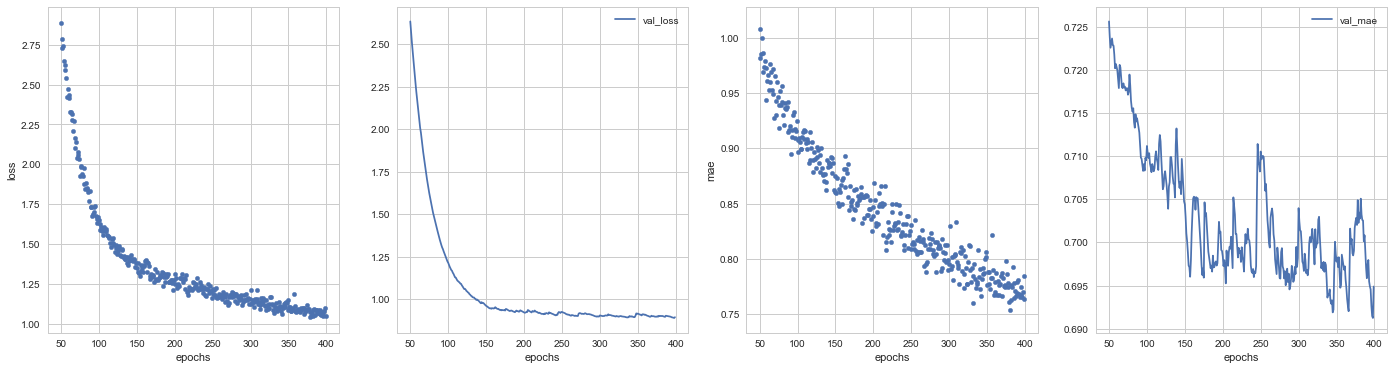

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


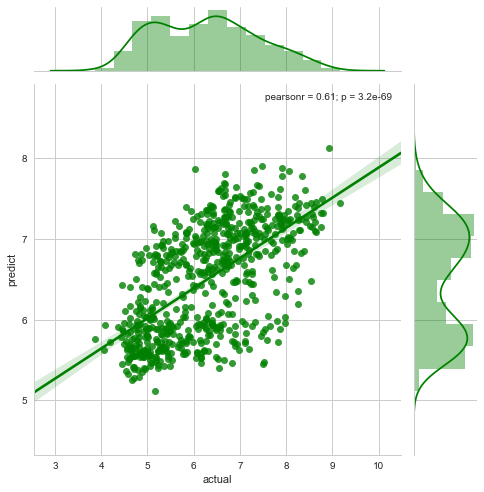

In [101]:
f, axes = plt.subplots(1, 4, figsize=(24,6))
skip=50
epochs = list(range(0, n_epochs))[skip:]
pd.DataFrame({'loss': history.history['loss'][skip:], 'epochs': epochs}).plot.scatter(x='epochs', y='loss', ax=axes[0])
pd.DataFrame({'val_loss': smooth_curve(history.history['val_loss'])[skip:], 'epochs': epochs}).plot(x='epochs', y='val_loss', ax=axes[1])
pd.DataFrame({'mae': history.history['mean_absolute_error'][skip:], 'epochs': epochs}).plot.scatter(x='epochs', y='mae', ax=axes[2])
pd.DataFrame({'val_mae': smooth_curve(history.history['val_mean_absolute_error'])[skip:], 'epochs': epochs}).plot(x='epochs', y='val_mae', ax=axes[3])
plt.show()

predictions_df = pd.DataFrame({'predict': network_01.predict(ALL_KI_X_test[ALL_KI_boruta_genes]).ravel(), 'actual': ALL_KI_y_test})
sns.jointplot("actual", "predict", data=predictions_df, kind="reg", color="g", size=7)
plt.show()

## 02 Sequential model: classification to predict region

* 1 boruta region genes

## 03 Functional model: classification and regression combined

* combine boruta gene sets:
    * regression -> log_AB
    * classification -> GT
    * classification -> region
* trian combined model